# 1. Importation des librairies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Ce module offre des classes capables de gérer des calendriers, de lister les jours fériés légaux / religieux
# et de fournir des fonctions de calcul liées aux jours ouvrables.

!pip install workalendar

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=b2fa58ab784ecf5e2df211b804555c7baa2dbe715c1679a2e7e8dc6a2787d216
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus


In [3]:
# Import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import xgboost
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LinearRegression, Ridge,ElasticNet,SGDRegressor,PassiveAggressiveRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from workalendar.europe import UnitedKingdom
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.inspection import permutation_importance

from joblib import dump, load

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 200
pd.options.display.max_rows = 800

sns.set_style('ticks')
sns.set_context('poster', font_scale = 0.5)

%matplotlib inline


# ***----- > Evaluation des modèles SANS Ajout de données***

# 2. Importation des données

In [4]:
# Chargement du fichier CSV dans un DataFrame
df = pd.read_csv("/content/drive/MyDrive/jun23_cda_pompiers/Exploration de données/DataFrames intermédiaires/df_SampleDistanceOK.csv")

df["DateOfCall"] = pd.to_datetime(df["DateOfCall"])

df = df[['AttendanceTime', 'DateOfCall', 'DayOfTheCall', 'MonthOfTheCall','HourOfCall','MomentOfTheDay', 'IsNight',
    'IncidentGroup', 'IncidentGroupType', 'PropertyCategory', 'PropertyType', 'AddressQualifier',
    'BoroughName', 'WardName', 'LatitudeIncident', 'LongitudeIncident', 'Region', 'Saison',
         'DeployedFromStationName', 'LatitudeStation', 'LongitudeStation', 'Distance', 'DeployedFromLocation', 'NumStationsWithPumpsAttending',
         'SecondPumpArrivingDeployedFromStation','NumCalls', 'ResourceCode']]

print(df.shape)
df.head()

(516372, 27)


,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode
0,5.13,2009-01-01,3.0,1,0.0,Late Night,1.0,Fire,Fire - Secondary Fire,Outdoor,Outdoor - Road surface/pavement,Street,Enfield,Haselbury,51.633342,-0.068488,North,Winter,Edmonton,51.625116,-0.060761,1.06,Home Station,1.0,No Second pump deloyed,2.0,A341
1,5.20,2009-01-01,3.0,1,7.0,Morning,1.0,Fire,Fire - Secondary Fire,Outdoor,Outdoor - Road surface/pavement,Street,Enfield,Bowes,51.614526,-0.100747,North,Winter,Edmonton,51.625116,-0.060761,3.00,Home Station,1.0,No Second pump deloyed,1.0,A342
2,4.90,2009-01-01,3.0,1,11.0,Morning,0.0,Special Service,Special Service - Road Traffic Collision,Vehicle,Vehicle - Car,Street,Enfield,Winchmore Hill,51.623381,-0.102804,North,Winter,Edmonton,51.625116,-0.060761,2.91,Home Station,2.0,Southgate,2.0,A341
3,7.53,2009-01-02,4.0,1,12.0,Morning,0.0,False Alarm,False Alarm - Automatic Fire Alarm,Non Residential,Non Residential - Public,Correct incident location,Enfield,Southbury,51.645206,-0.064283,North,Winter,Edmonton,51.625116,-0.060761,2.25,Home Station,1.0,No Second pump deloyed,2.0,A341
4,4.80,2009-01-02,4.0,1,17.0,Afternoon,1.0,Special Service,Special Service - Road Traffic Collision,Vehicle,Vehicle - Car,Street,Enfield,Upper Edmonton,51.611869,-0.078933,North,Winter,Edmonton,51.625116,-0.060761,1.93,Home Station,1.0,No Second pump deloyed,1.0,A342


In [5]:
df["YearOfTheCall"] = df["DateOfCall"].dt.year

In [6]:
df = df[df["YearOfTheCall"].isin([2015,2016,2017,2018,2019,2020,2021,2022])]
df.drop(["DateOfCall"],axis=1,inplace=True)

Le 9 janvier 2014, dix casernes de pompiers de Londres ont été fermées dans le cadre du Cinquième Plan de Sécurité de Londres (LSP5). Pour éviter toute influence sur nos résultats, nous avons décidé de supprimer toutes les données antérieures à 2014. Ainsi, les modèles seront entraînés uniquement sur les données recueillies entre 2015 et 2022. Nous avons décidé d’exclure les données de 2023, car l’année n’était pas encore terminée au moment de la collecte des données.

# 3. Création des pipelines de modélisation

#### 3A. Séparation du dataset en deux (Train/Test)

In [7]:
# Séparation des features (X) et de la variable cible (y)
X = df.drop('AttendanceTime', axis=1)
y = df['AttendanceTime']

# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Affichage de la forme des ensembles d'entraînement et de test
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (188659, 26)
y_train shape: (188659,)
X_test shape: (92923, 26)
y_test shape: (92923,)


#### 3B. Création d'une pipeline de modélisation

In [8]:
# Sélection automatique des features numériques et catégorielles
numeric_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)


# Création d'un transformateur pour les variables numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler()),
])

# Création d'un transformateur pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', sparse=True, handle_unknown='ignore')),
])

# Création du préprocesseur qui combine les transformateurs numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

In [9]:
regressors = {

    'XGBRegressor': XGBRegressor(random_state=42),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'PassiveAggressiveRegressor': PassiveAggressiveRegressor(random_state=42),
    'ElasticNet': ElasticNet(),
    'SGDRegressor':SGDRegressor(random_state=42),
    'GradientBoostingRegressor':GradientBoostingRegressor(random_state=42),
    'LGBMRegressor':LGBMRegressor(verbose=-100,random_state=42)
}

In [10]:
model_pip = {}

for name, model in regressors.items():
    model_pip[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('estimator', model)
    ])

model_pip['LinearRegression']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d0064717a00>),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d0064715d20>)])),
                ('estimator', LinearRegression())])

In [11]:
def evaluation(model):

    """
    Cette fonction évalue un modèle de régression avant l'optimisation de ses hyperparamètres.

    """

    # Récupération du nom de l'algorithme à partir du modèle
    algoname = str(model["estimator"]).split("(")[0]

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Prédiction sur les données d'entraînement et de test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcul des métriques d'évaluation
    Train_score = round(model.score(X_train, y_train), 2)
    Test_score= round(model.score(X_test, y_test), 2)
    Train_RMSE= round(mean_squared_error(y_train, y_train_pred, squared=False), 2)
    Test_RMSE= round(mean_squared_error(y_test, y_test_pred, squared=False), 2)

    return algoname, Train_score, Test_score, Train_RMSE, Test_RMSE


# 4. Evaluation des modèles

**Echelle interprétation R²**


- **R² < 0.3** : Cela indique que le modèle explique très peu de la variabilité de la variable de réponse. C’est généralement considéré comme un mauvais ajustement du modèle.

- **0.3 ≤ R² < 0.5** : Cela indique que le modèle explique une partie de la variabilité de la variable de réponse. C’est généralement considéré comme un ajustement faible du modèle.

- **0.5 ≤ R² < 0.7** : Cela indique que le modèle explique une quantité modérée de la variabilité de la variable de réponse. C’est généralement considéré comme un ajustement modéré du modèle.

- **0.7 ≤ R² < 0.9** : Cela indique que le modèle explique une grande partie de la variabilité de la variable de réponse. C’est généralement considéré comme un bon ajustement du modèle.

- **0.9 ≤ R² < 1** : Cela indique que le modèle explique presque toute la variabilité de la variable de réponse. C’est généralement considéré comme un excellent ajustement du modèle.

- **R² = 1**: Cela indique que le modèle explique toute la variabilité de la variable de réponse. C’est généralement considéré comme un ajustement parfait du modèle. Cependant, un R² de 1 peut aussi indiquer un surajustement (overfitting), surtout si votre modèle est complexe (par exemple, s’il a beaucoup de paramètres) et si vous avez peu de données.

In [12]:
# Liste des noms de modèles
model_names = [name for name, model in model_pip.items()]

# Initialisation d'une liste pour stocker les scores et les temps d'exécution
score = []

# Boucle pour évaluer chaque modèle
for name, model in model_pip.items():
    start_time = time.time()
    model_scores = list(evaluation(model))
    end_time = time.time()
    execution_time = round(end_time - start_time,2)
    model_scores.append(execution_time)
    score.append(model_scores)

# Création d'un DataFrame avec les scores et les temps d'exécution
data_score_before = pd.DataFrame(score,columns=['Model','Train score','Test score', 'Train RMSE', 'Test RMSE', 'Model Execution Time'])

# Tri des résultats par RMSE Test de manière ascendante
data_score_before.sort_values(by="Test score", ascending=False,ignore_index=True)


,Model,Train score,Test score,Train RMSE,Test RMSE,Model Execution Time
0,GradientBoostingRegressor,0.41,0.32,1.41,1.54,67.53
1,LGBMRegressor,0.49,0.29,1.32,1.57,14.63
2,XGBRegressor,0.52,0.26,1.27,1.60,10.89
3,SGDRegressor,0.44,0.19,1.38,1.67,7.45
4,ElasticNet,0.14,0.13,1.71,1.73,5.51
5,Ridge,0.45,-0.09,1.37,1.94,13.38
6,LinearRegression,0.45,-0.18,1.37,2.02,19.90
7,PassiveAggressiveRegressor,0.04,-0.47,1.80,2.26,6.29


<b> NOTES :</b> <br>
- Les performances des modèles sont très faibles. Le modèle ayant les meilleures peformances est : GradientBoostingRegressor.

# ***----- > Evaluation des modèles AVEC Ajout de données***

# 5. Ajout de nouvelles données

In [13]:
# Chargement du fichier CSV dans un DataFrame
df = pd.read_csv("/content/drive/MyDrive/jun23_cda_pompiers/Exploration de données/DataFrames intermédiaires/df_SampleDistanceOK.csv")

df["DateOfCall"] = pd.to_datetime(df["DateOfCall"])

df = df[['AttendanceTime', 'DateOfCall', 'DayOfTheCall', 'MonthOfTheCall','HourOfCall','MomentOfTheDay', 'IsNight',
    'IncidentGroup', 'IncidentGroupType', 'PropertyCategory', 'PropertyType', 'AddressQualifier',
    'BoroughName', 'WardName', 'LatitudeIncident', 'LongitudeIncident', 'Region', 'Saison',
         'DeployedFromStationName', 'LatitudeStation', 'LongitudeStation', 'Distance', 'DeployedFromLocation', 'NumStationsWithPumpsAttending',
         'SecondPumpArrivingDeployedFromStation','NumCalls', 'ResourceCode','DelayCodeDescription']]


In [14]:
df["YearOfTheCall"] = df["DateOfCall"].dt.year
df = df[df["YearOfTheCall"].isin([2015,2016,2017,2018,2019,2020,2021,2022])]
df.tail()

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall
516315,3.05,2022-12-23,4.0,12,22.0,Late Evening,1.0,Special Service,Special Service - Rescue,Residential,Residential - Nursing/Care Home/Hospice,Correct incident location,Havering,Heaton,51.596821,0.215786,East,Winter,Harold Hill,51.5946,0.2329,1.21,Home Station,1.0,No Second pump deloyed,1.0,F571,No Delay,2022
516316,5.32,2022-12-27,1.0,12,7.0,Morning,1.0,Special Service,Special Service - Environment,Residential,Residential - Nursing/Care Home/Hospice,Correct incident location,Havering,Harold Wood,51.591357,0.231874,East,Winter,Harold Hill,51.5946,0.2329,0.37,Home Station,1.0,No Second pump deloyed,1.0,F571,No Delay,2022
516317,4.27,2022-12-29,3.0,12,19.0,Early Evening,1.0,Special Service,Special Service - Road Traffic Collision,Vehicle,Vehicle - Multiple Vehicles,Street,Havering,Gooshays,51.609604,0.220380,East,Winter,Harold Hill,51.5946,0.2329,1.88,Home Station,2.0,Romford,1.0,F571,No Delay,2022
516318,4.70,2022-12-30,4.0,12,17.0,Afternoon,1.0,False Alarm,False Alarm - Automatic Fire Alarm,Residential,Residential - Retirement/Old Persons Home,Correct incident location,Havering,Harold Wood,51.590573,0.237685,East,Winter,Harold Hill,51.5946,0.2329,0.56,Home Station,2.0,Hornchurch,1.0,F571,No Delay,2022
516319,4.13,2022-12-30,4.0,12,19.0,Early Evening,1.0,Fire,Fire - Primary Fire,Residential,Residential - Hostel (e.g. for homeless people),Correct incident location,Havering,Gooshays,51.608006,0.218712,East,Winter,Harold Hill,51.5946,0.2329,1.78,Home Station,2.0,Romford,2.0,F571,No Delay,2022


#### 5A. Semaine et weekend

In [15]:
df["WeekOfTheCall"] = df["DateOfCall"].dt.strftime("%W")
df["WeekOfTheCall"] = df["WeekOfTheCall"].astype(int)

df["IsWeekend"] = df["DayOfTheCall"].apply(lambda x: 1 if x > 4 else 0)
df.head(1)

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend
3511,9.08,2015-01-01,3.0,1,0.0,Late Night,1.0,Fire,Fire - Primary Fire,Vehicle,Vehicle - Car,Street,Enfield,Grange Park,51.649162,-0.081229,North,Winter,Edmonton,51.625116,-0.060761,3.02,Home Station,1.0,No Second pump deloyed,2.0,A342,No Delay,2015,0,0


#### 5B. Jours travaillés

In [16]:
cal = UnitedKingdom()
df['IsWorkingDay'] = df['DateOfCall'].apply(lambda x: cal.is_working_day(x))
df['IsWorkingDay'] = df['IsWorkingDay'].astype(int)
df.head()

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay
3511,9.08,2015-01-01,3.0,1,0.0,Late Night,1.0,Fire,Fire - Primary Fire,Vehicle,Vehicle - Car,Street,Enfield,Grange Park,51.649162,-0.081229,North,Winter,Edmonton,51.625116,-0.060761,3.02,Home Station,1.0,No Second pump deloyed,2.0,A342,No Delay,2015,0,0,0
3512,5.43,2015-01-02,4.0,1,11.0,Morning,0.0,False Alarm,False Alarm - Automatic Fire Alarm,Residential,Residential - Retirement/Old Persons Home,Within same building,Enfield,Grange Park,51.635047,-0.091898,North,Winter,Edmonton,51.625116,-0.060761,2.42,Home Station,2.0,Southgate,1.0,A341,No Delay,2015,0,0,1
3513,7.32,2015-01-02,4.0,1,17.0,Afternoon,1.0,False Alarm,False alarm - Good intent,Vehicle,Vehicle - Car,Correct incident location,Enfield,Bowes,51.608751,-0.099501,North,Winter,Edmonton,51.625116,-0.060761,3.24,Home Station,1.0,No Second pump deloyed,1.0,A342,Traffic calming measures,2015,0,0,1
3514,3.63,2015-01-03,5.0,1,11.0,Morning,0.0,False Alarm,False Alarm - Automatic Fire Alarm,Residential,Residential - Nurses'/Doctors' accommodation,Within same building,Enfield,Edmonton Green,51.617274,-0.063104,North,Winter,Edmonton,51.625116,-0.060761,0.89,Home Station,2.0,Tottenham,1.0,A342,No Delay,2015,0,1,0
3515,3.90,2015-01-04,6.0,1,16.0,Afternoon,0.0,False Alarm,False alarm - Good intent,Vehicle,Vehicle - Car,Street,Enfield,Edmonton Green,51.624723,-0.064405,North,Winter,Edmonton,51.625116,-0.060761,0.26,Home Station,1.0,No Second pump deloyed,1.0,A342,No Delay,2015,0,1,0


#### 5C. Typologie du véhicule d'intervention

##### https://fire.fandom.com/wiki/London_Fire_Brigade#Brigade_Profile
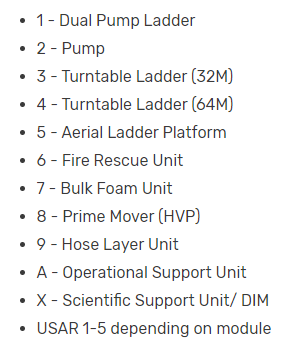

In [17]:
# Dictionnaire pour mapper les chiffres à leur signification
ResourceCodeAppliance = {
    '1': 'Dual Pump Ladder',
    '2' : "Pump",
    '3' : "Turntable Ladder (32M)",
    "4": "Turntable Ladder (64M)",
    "5" : "Aerial Ladder Platform",
    "6": "Fire Rescue Unit",
    "7" : "Bulk Foam Unit",
    "8" : "Prime Mover (HVP)",
    "9" : "Hose Layer Unit",
    "A"  :" Operational Support Unit",
    "X" :"Scientific Support Unit / DIM",
}

df['ResourceCodeAppliance'] = df['ResourceCode'].str[-1].map(ResourceCodeAppliance)
df.head()

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance
3511,9.08,2015-01-01,3.0,1,0.0,Late Night,1.0,Fire,Fire - Primary Fire,Vehicle,Vehicle - Car,Street,Enfield,Grange Park,51.649162,-0.081229,North,Winter,Edmonton,51.625116,-0.060761,3.02,Home Station,1.0,No Second pump deloyed,2.0,A342,No Delay,2015,0,0,0,Pump
3512,5.43,2015-01-02,4.0,1,11.0,Morning,0.0,False Alarm,False Alarm - Automatic Fire Alarm,Residential,Residential - Retirement/Old Persons Home,Within same building,Enfield,Grange Park,51.635047,-0.091898,North,Winter,Edmonton,51.625116,-0.060761,2.42,Home Station,2.0,Southgate,1.0,A341,No Delay,2015,0,0,1,Dual Pump Ladder
3513,7.32,2015-01-02,4.0,1,17.0,Afternoon,1.0,False Alarm,False alarm - Good intent,Vehicle,Vehicle - Car,Correct incident location,Enfield,Bowes,51.608751,-0.099501,North,Winter,Edmonton,51.625116,-0.060761,3.24,Home Station,1.0,No Second pump deloyed,1.0,A342,Traffic calming measures,2015,0,0,1,Pump
3514,3.63,2015-01-03,5.0,1,11.0,Morning,0.0,False Alarm,False Alarm - Automatic Fire Alarm,Residential,Residential - Nurses'/Doctors' accommodation,Within same building,Enfield,Edmonton Green,51.617274,-0.063104,North,Winter,Edmonton,51.625116,-0.060761,0.89,Home Station,2.0,Tottenham,1.0,A342,No Delay,2015,0,1,0,Pump
3515,3.90,2015-01-04,6.0,1,16.0,Afternoon,0.0,False Alarm,False alarm - Good intent,Vehicle,Vehicle - Car,Street,Enfield,Edmonton Green,51.624723,-0.064405,North,Winter,Edmonton,51.625116,-0.060761,0.26,Home Station,1.0,No Second pump deloyed,1.0,A342,No Delay,2015,0,1,0,Pump


In [18]:
df["ResourceCodeAppliance"].value_counts()

Dual Pump Ladder    198919
Pump                 82663
Name: ResourceCodeAppliance, dtype: int64

#### 5D. Profil des arrondissements (population, superficie, densité population)

In [19]:
#http://london-fire.labs.theodi.org/explore/
borough = pd.read_csv("/content/drive/MyDrive/jun23_cda_pompiers/Modélisation/Datasets/Borough.csv")
borough.head()

,borough,populationThousands,areaSqKm,populationDensity
0,Camden,235,22,10798
1,City of London,12,3,4029
2,Hackney,219,19,11499
3,Hammersmith and Fulham,170,16,10345
4,Haringey,225,30,7605


In [20]:
df = pd.merge(left=df,right=borough,left_on="BoroughName",right_on="borough",how="inner")
df.drop(["borough"],axis=1,inplace=True)

df = df.rename(columns={
    "populationThousands": "BoroughPopulationThousands",
    "areaSqKm": "BoroughAreaSqKm",
    "populationDensity": "BoroughPopulationDensity"
})

df.tail(1)

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance,BoroughPopulationThousands,BoroughAreaSqKm,BoroughPopulationDensity
281581,6.62,2022-09-15,3.0,9,13.0,Afternoon,0.0,Fire,Fire - Secondary Fire,Outdoor,Outdoor - Domestic garden (vegetation not equi...,On land associated with building,Harrow,North Harrow,51.58382,-0.362073,West,Autumn,Ruislip,51.579025,-0.431361,4.82,Home Station,2.0,Northolt,1.0,G321,No Delay,2022,37,0,1,Dual Pump Ladder,230,50,4558


#### 5E. Nombre de casernes par arrondissement

In [21]:
# # #https://www.london-fire.gov.uk/community/the-city-of-london/
nbstations = pd.read_excel("/content/drive/MyDrive/jun23_cda_pompiers/Modélisation/Datasets/NBStationByBorough.xlsx")
nbstations.head()

,Borough,NBStationsInBorough
0,Barking and Dagenham,2
1,Barnet,4
2,Bexley,3
3,Brent,3
4,Bromley,4


In [22]:
df = pd.merge(left=df,right=nbstations,left_on="BoroughName",right_on="Borough",how="inner")
df = df.rename(columns={
    "NBStationsInBorough": "NBPumpStationsInBorough",
})
df.drop(["Borough"],axis=1,inplace=True)
df.head(1)

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance,BoroughPopulationThousands,BoroughAreaSqKm,BoroughPopulationDensity,NBPumpStationsInBorough
0,9.08,2015-01-01,3.0,1,0.0,Late Night,1.0,Fire,Fire - Primary Fire,Vehicle,Vehicle - Car,Street,Enfield,Grange Park,51.649162,-0.081229,North,Winter,Edmonton,51.625116,-0.060761,3.02,Home Station,1.0,No Second pump deloyed,2.0,A342,No Delay,2015,0,0,0,Pump,295,81,3648,3


#### 5F. Type de routes par Arrondissement

In [23]:
#https://data.london.gov.uk/dataset/length-road-network-borough-and-region
road = pd.read_excel("/content/drive/MyDrive/jun23_cda_pompiers/Modélisation/Datasets/Road.xlsx")
road.head()

,Local Authority,All motorways,All Major Roads,All minor roads
0,Camden,0.0,38.6,238.8
1,City of London,0.0,12.4,35.3
2,Hackney,0.0,35.9,234.5
3,Hammersmith and Fulham,0.0,32.2,187.7
4,Haringey,0.0,38.7,315.1


In [24]:
df = pd.merge(left=df,right=road,left_on="BoroughName",right_on="Local Authority",how="inner")
df.drop(["Local Authority"],axis=1,inplace=True)
df = df.rename(columns={
    "All motorways": "BoroughTotalMotorwayKm",
    "All Major Roads": "BoroughTotalMajorRoadsKm",
    "All minor roads": "BoroughTotalMinorRoadsKm"
})
df.head(1)

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance,BoroughPopulationThousands,BoroughAreaSqKm,BoroughPopulationDensity,NBPumpStationsInBorough,BoroughTotalMotorwayKm,BoroughTotalMajorRoadsKm,BoroughTotalMinorRoadsKm
0,9.08,2015-01-01,3.0,1,0.0,Late Night,1.0,Fire,Fire - Primary Fire,Vehicle,Vehicle - Car,Street,Enfield,Grange Park,51.649162,-0.081229,North,Winter,Edmonton,51.625116,-0.060761,3.02,Home Station,1.0,No Second pump deloyed,2.0,A342,No Delay,2015,0,0,0,Pump,295,81,3648,3,11.2,91.7,543.3


#### 5G. Traffic flow

In [25]:
#https://data.london.gov.uk/dataset/traffic-flows-borough?q=traffic
traffic = pd.read_excel("/content/drive/MyDrive/jun23_cda_pompiers/Modélisation/Datasets/traffic-flow-borough.xlsx")
traffic.head()

,Local Authority,Année,Traffic flow
0,City of London,2009,170
1,City of London,2010,168
2,City of London,2011,164
3,City of London,2012,159
4,City of London,2013,159


In [26]:
df = pd.merge(left=df,right=traffic,left_on=["BoroughName","YearOfTheCall"],right_on=["Local Authority","Année"],how="inner")
df = df.rename(columns={
    "Traffic flow": "BoroughAnnualTrafficFlow"
})
df.drop(["Local Authority","Année"],axis=1,inplace=True)
df.head(1)

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance,BoroughPopulationThousands,BoroughAreaSqKm,BoroughPopulationDensity,NBPumpStationsInBorough,BoroughTotalMotorwayKm,BoroughTotalMajorRoadsKm,BoroughTotalMinorRoadsKm,BoroughAnnualTrafficFlow
0,9.08,2015-01-01,3.0,1,0.0,Late Night,1.0,Fire,Fire - Primary Fire,Vehicle,Vehicle - Car,Street,Enfield,Grange Park,51.649162,-0.081229,North,Winter,Edmonton,51.625116,-0.060761,3.02,Home Station,1.0,No Second pump deloyed,2.0,A342,No Delay,2015,0,0,0,Pump,295,81,3648,3,11.2,91.7,543.3,1741


#### 5H. Nombre d'intervention d'un camion dans le mois

In [27]:
#Compte cumulatif d'intervention au total fait par le camion à un temps donné
df = df.sort_values(['DateOfCall', 'ResourceCode'])
df['PumpInterventionCount'] = df.groupby(['ResourceCode', df['DateOfCall'].dt.to_period('M')]).cumcount() + 1
df.loc[df["ResourceCode"]=="H252"].sort_values(by="DateOfCall").head()

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance,BoroughPopulationThousands,BoroughAreaSqKm,BoroughPopulationDensity,NBPumpStationsInBorough,BoroughTotalMotorwayKm,BoroughTotalMajorRoadsKm,BoroughTotalMinorRoadsKm,BoroughAnnualTrafficFlow,PumpInterventionCount
214915,7.85,2015-01-01,3.0,1,17.0,Afternoon,1.0,Fire,Fire - Secondary Fire,Outdoor,Outdoor - Roadside furniture (eg lamp posts/ r...,Street,Southwark,Dulwich Wood,51.422052,-0.080084,Center,Winter,West Norwood,51.422688,-0.105758,1.78,Home Station,1.0,No Second pump deloyed,6.0,H252,No Delay,2015,0,0,0,Pump,287,29,9948,3,0.0,55.2,337.7,727,1
260067,4.25,2015-01-01,3.0,1,22.0,Late Evening,1.0,False Alarm,False alarm - Good intent,Outdoor,Outdoor - Road surface/pavement,Street,Lambeth,Knight's Hill,51.425150,-0.101344,Center,Winter,West Norwood,51.422688,-0.105758,0.41,Home Station,1.0,No Second pump deloyed,1.0,H252,No Delay,2015,0,0,0,Pump,284,27,10606,5,0.0,54.9,328.5,743,2
260068,5.43,2015-01-06,1.0,1,1.0,Late Night,1.0,False Alarm,False Alarm - Automatic Fire Alarm,Non Residential,Non Residential - Medical,Correct incident location,Lambeth,West Dulwich,51.437214,-0.094974,Center,Winter,West Norwood,51.422688,-0.105758,1.78,Home Station,1.0,No Second pump deloyed,1.0,H252,No Delay,2015,1,0,1,Pump,284,27,10606,5,0.0,54.9,328.5,743,3
260069,5.47,2015-01-07,2.0,1,9.0,Morning,0.0,False Alarm,False Alarm - Automatic Fire Alarm,Non Residential,Non Residential - Education,Within same building,Lambeth,Gipsy Hill,51.432012,-0.091967,Center,Winter,West Norwood,51.422688,-0.105758,1.41,Home Station,1.0,No Second pump deloyed,1.0,H252,No Delay,2015,1,0,1,Pump,284,27,10606,5,0.0,54.9,328.5,743,4
214916,3.32,2015-01-08,3.0,1,13.0,Afternoon,0.0,False Alarm,False alarm - Good intent,Non Residential,Non Residential - Medical,Within same building,Southwark,Dulwich Village,51.453126,-0.100716,Center,Winter,West Norwood,51.422688,-0.105758,3.40,Home Station,1.0,No Second pump deloyed,1.0,H252,No Delay,2015,1,0,1,Pump,287,29,9948,3,0.0,55.2,337.7,727,5


#### 5I. Temps d'intervention d'un camion, lors de l'intervention précédente

In [28]:
df = df.sort_values(['DateOfCall', 'ResourceCode'])
df['RessourcePreviousAttendanceTime'] = df.groupby('ResourceCode')['AttendanceTime'].shift(1)

#Gestion des NaNs
df['RessourcePreviousAttendanceTime'] = df.apply(lambda row: row['AttendanceTime'] if pd.isna(row['RessourcePreviousAttendanceTime']) else row['RessourcePreviousAttendanceTime'],
     axis=1 )

df.loc[df["ResourceCode"]=="H252"].sort_values(by="DateOfCall").head()


,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance,BoroughPopulationThousands,BoroughAreaSqKm,BoroughPopulationDensity,NBPumpStationsInBorough,BoroughTotalMotorwayKm,BoroughTotalMajorRoadsKm,BoroughTotalMinorRoadsKm,BoroughAnnualTrafficFlow,PumpInterventionCount,RessourcePreviousAttendanceTime
214915,7.85,2015-01-01,3.0,1,17.0,Afternoon,1.0,Fire,Fire - Secondary Fire,Outdoor,Outdoor - Roadside furniture (eg lamp posts/ r...,Street,Southwark,Dulwich Wood,51.422052,-0.080084,Center,Winter,West Norwood,51.422688,-0.105758,1.78,Home Station,1.0,No Second pump deloyed,6.0,H252,No Delay,2015,0,0,0,Pump,287,29,9948,3,0.0,55.2,337.7,727,1,7.85
260067,4.25,2015-01-01,3.0,1,22.0,Late Evening,1.0,False Alarm,False alarm - Good intent,Outdoor,Outdoor - Road surface/pavement,Street,Lambeth,Knight's Hill,51.425150,-0.101344,Center,Winter,West Norwood,51.422688,-0.105758,0.41,Home Station,1.0,No Second pump deloyed,1.0,H252,No Delay,2015,0,0,0,Pump,284,27,10606,5,0.0,54.9,328.5,743,2,7.85
260068,5.43,2015-01-06,1.0,1,1.0,Late Night,1.0,False Alarm,False Alarm - Automatic Fire Alarm,Non Residential,Non Residential - Medical,Correct incident location,Lambeth,West Dulwich,51.437214,-0.094974,Center,Winter,West Norwood,51.422688,-0.105758,1.78,Home Station,1.0,No Second pump deloyed,1.0,H252,No Delay,2015,1,0,1,Pump,284,27,10606,5,0.0,54.9,328.5,743,3,4.25
260069,5.47,2015-01-07,2.0,1,9.0,Morning,0.0,False Alarm,False Alarm - Automatic Fire Alarm,Non Residential,Non Residential - Education,Within same building,Lambeth,Gipsy Hill,51.432012,-0.091967,Center,Winter,West Norwood,51.422688,-0.105758,1.41,Home Station,1.0,No Second pump deloyed,1.0,H252,No Delay,2015,1,0,1,Pump,284,27,10606,5,0.0,54.9,328.5,743,4,5.43
214916,3.32,2015-01-08,3.0,1,13.0,Afternoon,0.0,False Alarm,False alarm - Good intent,Non Residential,Non Residential - Medical,Within same building,Southwark,Dulwich Village,51.453126,-0.100716,Center,Winter,West Norwood,51.422688,-0.105758,3.40,Home Station,1.0,No Second pump deloyed,1.0,H252,No Delay,2015,1,0,1,Pump,287,29,9948,3,0.0,55.2,337.7,727,5,5.47


5J. Cause de retard d'un camion lors de l'intervention précédente

In [29]:
df = df.sort_values(['DateOfCall', 'HourOfCall', 'ResourceCode'])

# Obtenir la 'DelayCodeDescription' précédente pour chaque 'ResourceCode' et 'DateOfCall'
df['PreviousDelayCodeDescription'] = df.groupby(['DateOfCall', 'ResourceCode'])['DelayCodeDescription'].shift(1)

# Gestion des NaNs :  chaque journée est traitée indépendamment et le premier PreviousDelayCodeDescription de chaque journée est “No Delay”.
df['PreviousDelayCodeDescription'] = df.apply(
    lambda row: "No Delay" if pd.isna(row['PreviousDelayCodeDescription']) else row['PreviousDelayCodeDescription'],
    axis=1 )

In [30]:
Delay_df = df.loc[df["ResourceCode"]=="A342"].sort_values(by="DateOfCall")
Delay_df[['DateOfCall',"DelayCodeDescription","PreviousDelayCodeDescription"]].head(20)

,DateOfCall,DelayCodeDescription,PreviousDelayCodeDescription
0,2015-01-01,No Delay,No Delay
2,2015-01-02,Traffic calming measures,No Delay
3,2015-01-03,No Delay,No Delay
4,2015-01-04,No Delay,No Delay
6,2015-01-06,"Traffic, roadworks, etc",No Delay
10,2015-01-09,No Delay,No Delay
11,2015-01-12,No Delay,No Delay
12,2015-01-12,"Traffic, roadworks, etc",No Delay
16,2015-01-16,Arrived but held up - Other reason,No Delay
17,2015-01-16,"Traffic, roadworks, etc",Arrived but held up - Other reason


#### 5K. Temps d'intervention d'une station, lors de l'intervention précédente

In [31]:
df = df.sort_values(['DateOfCall', 'DeployedFromStationName'])
df['StationPreviousAttendanceTime'] = df.groupby('DeployedFromStationName')['AttendanceTime'].shift(1)

#Gestion des NaNs
df['StationPreviousAttendanceTime'] = df.apply(lambda row: row['AttendanceTime'] if pd.isna(row['StationPreviousAttendanceTime']) else row['StationPreviousAttendanceTime'],
     axis=1)

df.head()


,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance,BoroughPopulationThousands,BoroughAreaSqKm,BoroughPopulationDensity,NBPumpStationsInBorough,BoroughTotalMotorwayKm,BoroughTotalMajorRoadsKm,BoroughTotalMinorRoadsKm,BoroughAnnualTrafficFlow,PumpInterventionCount,RessourcePreviousAttendanceTime,PreviousDelayCodeDescription,StationPreviousAttendanceTime
77279,6.17,2015-01-01,3.0,1,23.0,Late Evening,1.0,False Alarm,False Alarm - Automatic Fire Alarm,Non Residential,Non Residential - Industry,Correct incident location,Hounslow,Chiswick Gunnersbury,51.488443,-0.257842,West,Winter,Acton,51.507054,-0.276920,2.46,Home Station,1.0,No Second pump deloyed,1.0,G261,No Delay,2015,0,0,0,Dual Pump Ladder,237,56,4229,3,9.8,82.3,417.5,1653,1,6.17,No Delay,6.17
229544,4.70,2015-01-01,3.0,1,0.0,Late Night,1.0,Special Service,Special Service - Road Traffic Collision,Vehicle,Vehicle - Car,Street,Croydon,South Croydon,51.362452,-0.068299,South,Winter,Addington,51.358043,-0.032222,2.55,Home Station,1.0,Addington,1.0,H262,No Delay,2015,0,0,0,Pump,346,87,3994,5,0.0,78.1,695.3,1331,1,4.70,No Delay,4.70
229545,7.28,2015-01-01,3.0,1,12.0,Morning,0.0,False Alarm,False Alarm - Automatic Fire Alarm,Residential,Residential - Retirement/Old Persons Home,Correct incident location,Croydon,Sanderstead,51.332722,-0.074903,South,Winter,Addington,51.358043,-0.032222,4.09,Home Station,2.0,Purley,1.0,H261,No Delay,2015,0,0,0,Dual Pump Ladder,346,87,3994,5,0.0,78.1,695.3,1331,1,7.28,No Delay,4.70
207225,4.07,2015-01-01,3.0,1,17.0,Afternoon,1.0,Fire,Fire - Secondary Fire,Outdoor,Outdoor - Large refuse/rubbish container (eg s...,On land associated with building,Barking and Dagenham,Barking Riverside,51.527908,0.110793,East,Winter,Barking,51.529820,0.088809,1.54,Home Station,1.0,No Second pump deloyed,1.0,F432,No Delay,2015,0,0,0,Pump,180,36,4980,2,0.0,37.3,305.0,653,2,4.82,No Delay,4.07
191489,8.58,2015-01-01,3.0,1,20.0,Early Evening,1.0,Fire,Fire - Primary Fire,Non Residential,Non Residential - Retail,Within same building,Redbridge,Ilford Town,51.561636,0.085359,East,Winter,Barking,51.529820,0.088809,3.55,Other Station,2.0,Barking,5.0,F411,Arrived but held up - Other reason,2015,0,0,0,Dual Pump Ladder,271,56,4795,3,4.0,62.0,474.8,1165,1,8.58,No Delay,4.07


#### 5L. Volume d'appel par Jour / heure / Arrondissement

In [32]:
df['DateHourBorough'] = df['DateOfCall'].astype(str) + df['HourOfCall'].astype(str) + df['BoroughName']
df['BoroughCallsPerDay'] = df.groupby('DateHourBorough')['DateHourBorough'].transform('count')
df.sample(5)

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance,BoroughPopulationThousands,BoroughAreaSqKm,BoroughPopulationDensity,NBPumpStationsInBorough,BoroughTotalMotorwayKm,BoroughTotalMajorRoadsKm,BoroughTotalMinorRoadsKm,BoroughAnnualTrafficFlow,PumpInterventionCount,RessourcePreviousAttendanceTime,PreviousDelayCodeDescription,StationPreviousAttendanceTime,DateHourBorough,BoroughCallsPerDay
276784,4.15,2016-11-19,5.0,11,9.0,Morning,0.0,Special Service,Special Service - Road Traffic Collision,Vehicle,Vehicle - Car,Street,Harrow,Canons,51.612176,-0.299311,West,Autumn,Stanmore,51.603654,-0.297587,0.95,Home Station,2.0,Mill Hill,1.0,G221,No Delay,2016,46,1,0,Dual Pump Ladder,230,50,4558,2,1.0,41.7,430.6,661,11,4.73,No Delay,6.08,2016-11-199.0Harrow,1
248128,3.95,2019-03-26,1.0,3,8.0,Morning,0.0,False Alarm,False Alarm - Automatic Fire Alarm,Non Residential,Non Residential - Public,Within same building,Merton,Merton Park,51.401350,-0.196132,South,Spring,Wimbledon,51.415588,-0.197463,1.59,Home Station,1.0,No Second pump deloyed,1.0,H341,No Delay,2019,12,0,1,Dual Pump Ladder,209,38,5552,2,0.0,42.4,332.7,677,28,5.25,No Delay,3.35,2019-03-268.0Merton,1
148261,5.05,2016-10-15,5.0,10,1.0,Late Night,1.0,Special Service,Special Service - Medical,Outdoor,Outdoor - Road surface/pavement,Street,Newham,Canning Town North,51.516895,0.010340,East,Autumn,Plaistow,51.516784,0.032048,1.50,Home Station,1.0,No Second pump deloyed,1.0,F451,No Delay,2016,41,1,0,Dual Pump Ladder,240,36,6629,3,0.0,54.5,375.4,925,21,4.43,No Delay,4.43,2016-10-151.0Newham,1
272714,5.67,2018-05-13,6.0,5,19.0,Early Evening,1.0,Special Service,Special Service - Rescue,Outdoor,Outdoor - Park,Street,Kingston upon Thames,Hook & Chessington North,51.372021,-0.306730,South,Spring,Surbiton,51.393769,-0.298722,2.48,Home Station,1.0,No Second pump deloyed,1.0,H391,No Delay,2018,19,1,0,Dual Pump Ladder,169,37,4536,3,0.0,44.6,298.4,986,11,5.57,No Delay,7.53,2018-05-1319.0Kingston upon Thames,1
184354,4.13,2016-03-03,3.0,3,1.0,Late Night,1.0,False Alarm,False Alarm - Automatic Fire Alarm,Non Residential,Non Residential - Medical,Correct incident location,Wandsworth,Tooting Broadway,51.426250,-0.174517,South,Spring,Tooting,51.439512,-0.163770,1.65,Home Station,1.0,Tooting,1.0,H351,No Delay,2016,9,0,1,Dual Pump Ladder,290,34,8451,3,0.0,56.5,373.5,760,3,3.58,No Delay,3.58,2016-03-031.0Wandsworth,1


In [33]:
# Vérification du code :
df[(df["DateOfCall"] == "2017-04-06") & (df["BoroughName"] == "Westminster") & (df["HourOfCall"] == 12.0)]

,AttendanceTime,DateOfCall,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,DelayCodeDescription,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance,BoroughPopulationThousands,BoroughAreaSqKm,BoroughPopulationDensity,NBPumpStationsInBorough,BoroughTotalMotorwayKm,BoroughTotalMajorRoadsKm,BoroughTotalMinorRoadsKm,BoroughAnnualTrafficFlow,PumpInterventionCount,RessourcePreviousAttendanceTime,PreviousDelayCodeDescription,StationPreviousAttendanceTime,DateHourBorough,BoroughCallsPerDay
96327,3.88,2017-04-06,3.0,4,12.0,Morning,0.0,Fire,Fire - Secondary Fire,Outdoor,Outdoor - Small refuse/rubbish container,Street,Westminster,Hyde Park,51.515511,-0.175635,Center,Spring,Paddington,51.520026,-0.183087,0.72,Home Station,1.0,No Second pump deloyed,1.0,A212,No Delay,2017,14,0,1,Pump,253,21,11784,2,0.0,60.0,275.8,861,3,1.60,No Delay,5.72,2017-04-0612.0Westminster,2
96328,4.72,2017-04-06,3.0,4,12.0,Morning,0.0,Special Service,Special Service - Road Traffic Collision,Vehicle,Vehicle - Car,Street,Westminster,Church Street,51.524519,-0.172046,Center,Spring,Paddington,51.520026,-0.183087,0.91,Home Station,1.0,Paddington,2.0,A212,No Delay,2017,14,0,1,Pump,253,21,11784,2,0.0,60.0,275.8,861,4,3.88,No Delay,3.88,2017-04-0612.0Westminster,2


#### Suppression des variables inutiles

In [34]:
df.drop(["DateOfCall","DateHourBorough","DelayCodeDescription"],axis=1,inplace=True)

#### Vérification du nombre d'arrondissement (valeur attendue = 33)

In [35]:
df["BoroughName"].nunique()

33

In [36]:
df.to_csv("/content/drive/MyDrive/jun23_cda_pompiers/Modélisation/df_EnrichiModelisation.csv", encoding='utf-8', index=False)

# 6. Ré-Evaluation des modèles

**Echelle interprétation R²**


- **R² < 0.3** : Cela indique que le modèle explique très peu de la variabilité de la variable de réponse. C’est généralement considéré comme un mauvais ajustement du modèle.

- **0.3 ≤ R² < 0.5** : Cela indique que le modèle explique une partie de la variabilité de la variable de réponse. C’est généralement considéré comme un ajustement faible du modèle.

- **0.5 ≤ R² < 0.7** : Cela indique que le modèle explique une quantité modérée de la variabilité de la variable de réponse. C’est généralement considéré comme un ajustement modéré du modèle.

- **0.7 ≤ R² < 0.9** : Cela indique que le modèle explique une grande partie de la variabilité de la variable de réponse. C’est généralement considéré comme un bon ajustement du modèle.

- **0.9 ≤ R² < 1** : Cela indique que le modèle explique presque toute la variabilité de la variable de réponse. C’est généralement considéré comme un excellent ajustement du modèle.

- **R² = 1**: Cela indique que le modèle explique toute la variabilité de la variable de réponse. C’est généralement considéré comme un ajustement parfait du modèle. Cependant, un R² de 1 peut aussi indiquer un surajustement (overfitting), surtout si votre modèle est complexe (par exemple, s’il a beaucoup de paramètres) et si vous avez peu de données.

In [37]:
# Séparation des features (X) et de la variable cible (y)
X = df.drop('AttendanceTime', axis=1)
y = df['AttendanceTime']

# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Affichage de la forme des ensembles d'entraînement et de test
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (188659, 43)
y_train shape: (188659,)
X_test shape: (92923, 43)
y_test shape: (92923,)


In [38]:
# Liste des modèles de régression à évaluer
models = model_pip

# Initialisation d'une liste pour stocker les scores et les temps d'exécution
score = []

# Boucle pour évaluer chaque modèle
for name, model in models.items():
    start_time = time.time()
    model_scores = list(evaluation(model))
    end_time = time.time()
    execution_time = round(end_time - start_time,2)
    model_scores.append(execution_time)
    score.append(model_scores)

# Création d'un DataFrame avec les scores et les temps d'exécution
data_score_after = pd.DataFrame(score, columns=['Model', 'Train score','Test score', 'Train RMSE', 'Test RMSE', 'Execution Time'])

# Tri des résultats par RMSE Test de manière ascendante
data_score_after.sort_values(by="Test score", ascending=False, ignore_index=True)


,Model,Train score,Test score,Train RMSE,Test RMSE,Execution Time
0,XGBRegressor,0.52,0.48,1.28,1.34,13.60
1,LGBMRegressor,0.48,0.47,1.33,1.35,18.61
2,LinearRegression,0.44,0.44,1.37,1.39,35.19
3,Ridge,0.44,0.44,1.37,1.39,22.60
4,SGDRegressor,0.43,0.43,1.39,1.40,8.89
5,GradientBoostingRegressor,0.41,0.41,1.42,1.42,127.76
6,ElasticNet,0.13,0.13,1.72,1.73,7.22
7,PassiveAggressiveRegressor,-0.01,0.07,1.85,1.79,8.44


________________________________________________________________________________

---

___________________________________________________________________________________________________________________________________________

### **Synthèse résultats pour R²**

In [39]:
score  = pd.merge(data_score_before,data_score_after,on="Model",how="inner",suffixes=["","_AFTER"])
RScore = score[["Model","Train score","Train score_AFTER","Test score","Test score_AFTER"]].sort_values(by="Test score_AFTER", ascending=False, ignore_index=True)
RScore["Test score_DIFF"] =  RScore["Test score_AFTER"]-RScore["Test score"]
RScore.sort_values(by="Test score_AFTER",ascending=False,ignore_index=True)

,Model,Train score,Train score_AFTER,Test score,Test score_AFTER,Test score_DIFF
0,XGBRegressor,0.52,0.52,0.26,0.48,0.22
1,LGBMRegressor,0.49,0.48,0.29,0.47,0.18
2,LinearRegression,0.45,0.44,-0.18,0.44,0.62
3,Ridge,0.45,0.44,-0.09,0.44,0.53
4,SGDRegressor,0.44,0.43,0.19,0.43,0.24
5,GradientBoostingRegressor,0.41,0.41,0.32,0.41,0.09
6,ElasticNet,0.14,0.13,0.13,0.13,0.00
7,PassiveAggressiveRegressor,0.04,-0.01,-0.47,0.07,0.54


### **Synthèse résultats pour le RMSE**

In [40]:
score  = pd.merge(data_score_before,data_score_after,on="Model",how="inner",suffixes=["","_AFTER"])
RMse = score[["Model","Train RMSE","Train RMSE_AFTER","Test RMSE","Test RMSE_AFTER"]].sort_values(by="Test RMSE_AFTER", ascending=False, ignore_index=True)
RMse["Test RMSE_DIFF"] =  RMse["Test RMSE_AFTER"]-RMse["Test RMSE"]

RMse.sort_values(by="Test RMSE_AFTER",ascending=True,ignore_index=True)

,Model,Train RMSE,Train RMSE_AFTER,Test RMSE,Test RMSE_AFTER,Test RMSE_DIFF
0,XGBRegressor,1.27,1.28,1.60,1.34,-0.26
1,LGBMRegressor,1.32,1.33,1.57,1.35,-0.22
2,LinearRegression,1.37,1.37,2.02,1.39,-0.63
3,Ridge,1.37,1.37,1.94,1.39,-0.55
4,SGDRegressor,1.38,1.39,1.67,1.40,-0.27
5,GradientBoostingRegressor,1.41,1.42,1.54,1.42,-0.12
6,ElasticNet,1.71,1.72,1.73,1.73,0.00
7,PassiveAggressiveRegressor,1.80,1.85,2.26,1.79,-0.47


<b> NOTES :</b> <br>
- Les 3 meilleurs models sont : LGBMRegressor,XGBRegressor et LinearRegression.
- Nous avons choisi d'optimiser le modèle de Ridge au lieu de LinearRegression car Ridge présente + d'hyperparamètres.

# ***----- > Optimisation des 3 meilleurs modèles***

# 7. Réglage des hyperparamètres



### 7A. Optimisation du modèle : XGBRegressor

**Le modèle XGBRegressor** fait partie de la bibliothèque XGBoost (Extreme Gradient Boosting).


---

La première étape consiste à créer un premier modèle de base. Il est entraîné sur les données.

Ensuite, un second modèle est construit pour tenter de corriger les erreurs présentes dans le premier modèle. Les erreurs sont minimisées par l’algorithme de descente de gradient, chaque arbre ajouté va compenser les erreurs commises précédemment sans détériorer les prédictions qui ont été justes en changeant en cours de route la base d'apprentissage.

Cette procédure se poursuit et des modèles sont ajoutés jusqu’à ce que l’ensemble complet des données de formation soit prédit correctement ou que le nombre maximal de modèles soit ajouté.

Les prédictions du dernier modèle ajouté seront les prédictions globales fournies par les anciens modèles d’arbres.

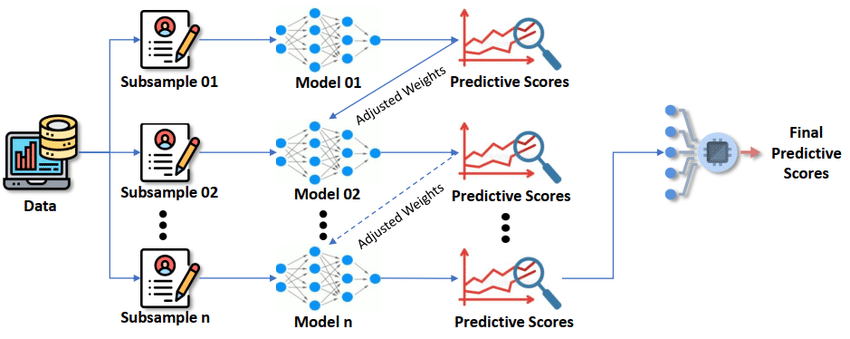

**Choix de l'approche :** Hyperopt utilise une approche appelée optimisation bayésienne. Au lieu de tester un nombre fixe de combinaisons d’hyperparamètres comme le fait GridSearchCV, ou de choisir au hasard comme le fait RandomizedSearchCV, Hyperopt utilise des informations sur les essais précédents pour choisir les hyperparamètres à tester ensuite. L’idée est de passer plus de temps à tester les hyperparamètres qui sont susceptibles de donner de meilleurs résultats.

In [41]:
# space = {
#      'estimator__colsample_bytree': hp.uniform('estimator__colsample_bytree', 0.5, 1.0),
#      'estimator__learning_rate': hp.loguniform('estimator__learning_rate', np.log(0.01), np.log(0.2)),
#      'estimator__max_depth': hp.choice('estimator__max_depth', range(3, 10)),
#      'estimator__n_estimators': hp.choice('estimator__n_estimators', range(100, 1000)),
#      'estimator__min_child_weight': hp.choice('estimator__min_child_weight', range(1, 6)),

#  }

#  # Fonction objectif
# def objective(params):
#      params = {
#         'estimator__colsample_bytree': float(params['estimator__colsample_bytree']),
#         'estimator__learning_rate': float(params['estimator__learning_rate']),
#         'estimator__max_depth': int(params['estimator__max_depth']),
#         'estimator__n_estimators': int(params['estimator__n_estimators']),
#         'estimator__min_child_weight': int(params['estimator__min_child_weight'])
#      }

#      reg = model_pip['XGBRegressor'].set_params(**params)
#      reg.fit(X_train, y_train)

#      preds = reg.predict(X_test)
#      score = np.sqrt(mean_squared_error(y_test, preds))

#      return {'loss': score, 'status': STATUS_OK}

# # Exécution de l'optimisation
# trials = Trials()
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# print("Best parameters: ", best)

# # 100%|██████████| 50/50 [27:28<00:00, 32.98s/trial, best loss: 1.3048701957347089]
# # Best parameters:  {'estimator__colsample_bytree': 0.7746831999163204, 'estimator__learning_rate': 0.0624207548570334, 'estimator__max_depth': 6, 'estimator__min_child_weight': 1, 'estimator__n_estimators': 685}

In [42]:
XGBRegressor_pip_tuning = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', XGBRegressor(
       colsample_bytree = 0.7746831999163204,  # Valeur par défaut : 1
       learning_rate = 0.0624207548570334,  # Valeur par défaut : 0.3
       max_depth = 6,  # Valeur par défaut : 6
       min_child_weight = 1,  # Valeur par défaut : 1
       n_estimators = 685,  # Valeur par défaut : 100
       random_state=0))
])

### 7B. Optimisation du modèle : LGBMRegressor

Le modèle LGBMRegressor de la bibliothèque LightGBM est une implémentation de l’algorithme de boosting de gradient. C'est une version améliorée de XGBoost


---


LightGBM est beaucoup plus rapide que XGBoost. Grâce à sa méthode de réduction de dimension, il est capable de gagner en matière de puissance de calcul tout en conservant la même précision de XGBoost.

In [43]:
# space = {
#      'estimator__colsample_bytree': hp.uniform('estimator__colsample_bytree', 0.5, 1.0),
#      'estimator__learning_rate': hp.loguniform('estimator__learning_rate', np.log(0.01), np.log(0.2)),
#      'estimator__max_depth': hp.choice('estimator__max_depth', range(3, 10)),
#      'estimator__n_estimators': hp.choice('estimator__n_estimators', range(100, 1000)),
#      'estimator__min_child_weight': hp.choice('estimator__min_child_weight', range(1, 6)),
#  }

# # Fonction objectif
# def objective(params):
#      params = {
#          'estimator__colsample_bytree': float(params['estimator__colsample_bytree']),
#          'estimator__learning_rate': float(params['estimator__learning_rate']),
#          'estimator__max_depth': int(params['estimator__max_depth']),
#          'estimator__n_estimators': int(params['estimator__n_estimators']),
#          'estimator__min_child_weight': int(params['estimator__min_child_weight'])
#      }

#      reg = model_pip['LGBMRegressor'].set_params(**params)
#      reg.fit(X_train, y_train)

#      preds = reg.predict(X_test)
#      score = np.sqrt(mean_squared_error(y_test, preds))

#      return {'loss': score, 'status': STATUS_OK}

# # Exécution de l'optimisation
# trials = Trials()
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# print("Best parameters: ", best)

# # 100%|██████████| 50/50 [20:58<00:00, 25.18s/trial, best loss: 1.305430304499525]
# # Best parameters:  {'estimator__colsample_bytree': 0.9194586567111567, 'estimator__learning_rate': 0.19789386803938744, 'estimator__max_depth': 5, 'estimator__min_child_weight': 3, 'estimator__n_estimators': 441}

In [44]:
LGBMRegressor_pip_tuning = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', LGBMRegressor(
      colsample_bytree = 0.9194586567111567, # Valeur par défaut : 1
      learning_rate=0.19789386803938744, # Valeur par défaut : 0.1
      max_depth=5, # Valeur par défaut : -1 (pas de limite)
      min_child_weight = 3, # Valeur par défaut : 0.001
      n_estimators=441, # Valeur par défaut : 100
      verbose=-100, # Valeur par défaut : -1 (pas de verbosité)
      random_state=0))
])

### 7C. Optimisation du modèle : Ridge

Comme la régression linéaire, la régression Ridge estime une variable cible en fonction de plusieurs variables prédictives. L’objectif de la régression Ridge est de trouver les coefficients qui minimisent la somme des carrés d’erreur tout en appliquant une pénalité à ces coefficients.  Le paramètre de régularisation, souvent noté λ ou alpha, contrôle l’effet de la régularisation1. Si λ est nul, cela nous donne l’équation de régression classique. Plus les valeurs de λ sont élevées, plus la pénalité est importante.

In [45]:
# space = {
#      'estimator__alpha': hp.uniform('estimator__alpha', 1, 250),
#  }

# # Fonction objectif
# def objective(params):
#      params = {
#          'estimator__alpha': int(params['estimator__alpha']),

#      }

#      reg = model_pip['Ridge'].set_params(**params)
#      reg.fit(X_train, y_train)

#      preds = reg.predict(X_test)
#      score = np.sqrt(mean_squared_error(y_test, preds))

#      return {'loss': score, 'status': STATUS_OK}

# # Exécution de l'optimisation
# trials = Trials()
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# print("Best parameters: ", best)

# # 100%|██████████| 50/50 [08:10<00:00,  9.81s/trial, best loss: 1.3870966317176971]
# # Best parameters:  {'estimator__alpha': 9.372353071731432}

In [46]:
Ridge_pip_tuning = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', Ridge(
      alpha =  9.372353071731432, # Valeur par défaut : 1
      ))
])



---



---



---



In [47]:
eval_Ridge = evaluation(Ridge_pip_tuning)
eval_XGBRegressor = evaluation(XGBRegressor_pip_tuning)
eval_LGBMRegressor = evaluation(LGBMRegressor_pip_tuning)

### 7D. Synthèse des résultats

In [48]:
XGBRegressor_after = {'Model':eval_XGBRegressor[0],
                  'Train score_Tun':eval_XGBRegressor[1],
                  'Test score_Tun':eval_XGBRegressor[2],
                  'Train RMSE_Tun':eval_XGBRegressor[3],
                  'Test RMSE_Tun':eval_XGBRegressor[4]}

LGBMRegressor_after = {'Model':eval_LGBMRegressor[0],
                  'Train score_Tun':eval_LGBMRegressor[1],
                  'Test score_Tun':eval_LGBMRegressor[2],
                  'Train RMSE_Tun':eval_LGBMRegressor[3],
                  'Test RMSE_Tun':eval_LGBMRegressor[4]}

Ridge_after = {'Model':eval_Ridge[0],
                  'Train score_Tun':eval_Ridge[1],
                  'Test score_Tun':eval_Ridge[2],
                  'Train RMSE_Tun':eval_Ridge[3],
                  'Test RMSE_Tun':eval_Ridge[4]}

data_score_Tun = pd.DataFrame([XGBRegressor_after, LGBMRegressor_after, Ridge_after])

### **Synthèse résultats pour R²**

In [49]:
score  = pd.merge(data_score_after,data_score_Tun,on="Model",how="inner")
Tun_Rscore = score[["Model","Train score","Train score_Tun","Test score","Test score_Tun"]].sort_values(by="Test score_Tun",
                                                                                                        ascending=False,
                                                                                                        ignore_index=True)

Tun_Rscore["Test score_DIFF"] =  Tun_Rscore["Test score_Tun"]-Tun_Rscore["Test score"]
Tun_Rscore.sort_values(by="Test score_Tun",ascending=False)


,Model,Train score,Train score_Tun,Test score,Test score_Tun,Test score_DIFF
0,XGBRegressor,0.52,0.54,0.48,0.49,0.01
1,LGBMRegressor,0.48,0.54,0.47,0.49,0.02
2,Ridge,0.44,0.44,0.44,0.44,0.00


### **Synthèse résultats pour RMSE**

In [50]:
score  = pd.merge(data_score_after,data_score_Tun,on="Model",how="inner")
Tun_RMse = score[["Model","Train RMSE","Train RMSE_Tun","Test RMSE","Test RMSE_Tun"]].sort_values(by="Test RMSE_Tun",
                                                                                                  ascending=False,
                                                                                                  ignore_index=True)

Tun_RMse["Test RMSE_DIFF"] =  Tun_RMse["Test RMSE_Tun"]-Tun_RMse["Test RMSE"]
Tun_RMse.sort_values(by="Test RMSE_Tun",ascending=True)


,Model,Train RMSE,Train RMSE_Tun,Test RMSE,Test RMSE_Tun,Test RMSE_DIFF
2,XGBRegressor,1.28,1.25,1.34,1.32,-0.02
1,LGBMRegressor,1.33,1.25,1.35,1.33,-0.02
0,Ridge,1.37,1.37,1.39,1.39,0.00


<b> NOTES :</b> <br>
- Les 2 meilleures modèles sont : LGBMRegressor et XGBRegressor.

### 7E. Features Importances

In [51]:
def feature_importances_graph(model):
    """
    Cette fonction génère un graphique des importances des features.

    """

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Calcul des importances des variables explicatives à l'aide de la permutation
    feature_importances = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42)

    # Création d'un DataFrame avec les noms des variables explicatives et leurs importances
    importances_df = pd.DataFrame({
        "Features": X.columns,
        "Importance": feature_importances.importances_mean
    })

    # Tri des variables explicatives par ordre d'importance croissante
    importances_df = importances_df.sort_values(by="Importance", ascending=True).tail(12)

    # Tracé d'un graphique à barres horizontales
    plt.grid(visible=True, linewidth=0.5)
    plt.barh(y=importances_df["Features"], width=importances_df["Importance"], color="skyblue")
    plt.xlabel("Average impact on model output")
    plt.ylabel("Features")


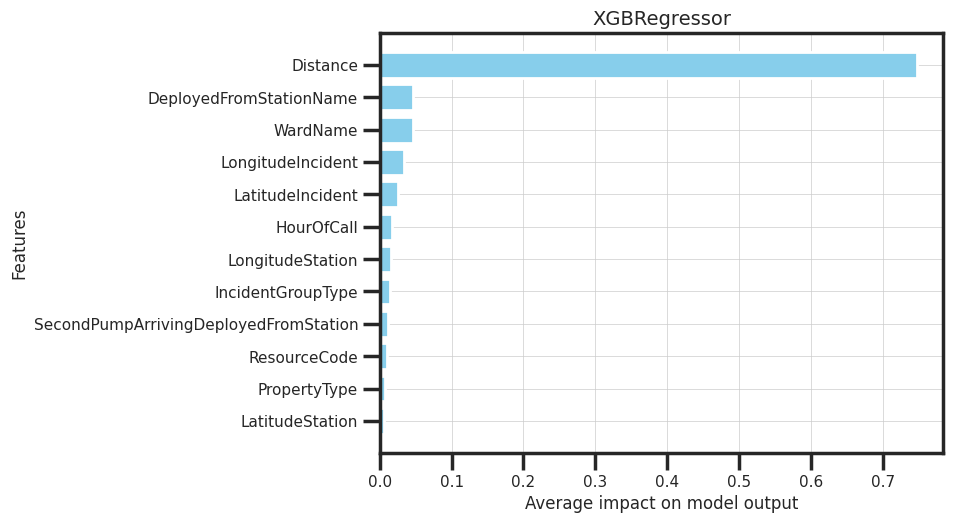

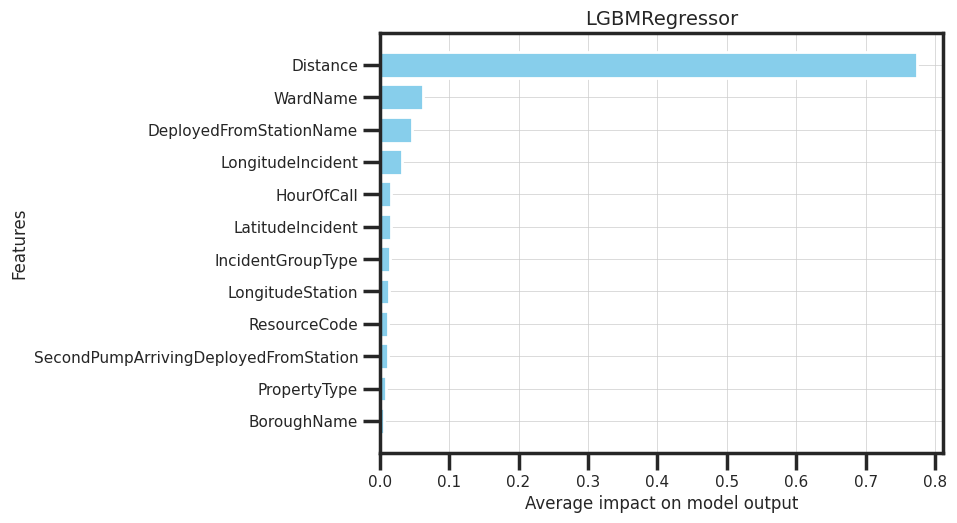

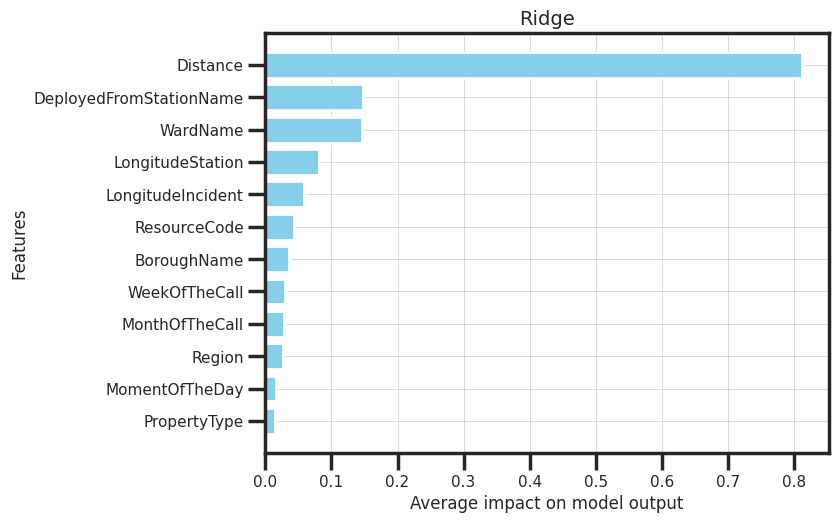

In [52]:
# Liste des modèles à évaluer après l'optimisation des hyperparamètres
models = [XGBRegressor_pip_tuning,
          LGBMRegressor_pip_tuning,
          Ridge_pip_tuning
          ]

# Pour chaque modèle, générer un graphique des importances des features
for i, model in enumerate(models):
    plt.figure(figsize=(16, 12))
    plt.subplot(2, 2, i + 1)
    feature_importances_graph(model)
    plt.title(str(model["estimator"]).split("(")[0], fontsize=14)


<b> NOTES :</b> <br>
- Nous constatons que ces deux modèles attribuent de l’importance aux mêmes variables.

# 8. choix d'un modèle


In [53]:
df = pd.read_csv("/content/drive/MyDrive/jun23_cda_pompiers/Modélisation/df_EnrichiModelisation.csv")
df.head()

,AttendanceTime,DayOfTheCall,MonthOfTheCall,HourOfCall,MomentOfTheDay,IsNight,IncidentGroup,IncidentGroupType,PropertyCategory,PropertyType,AddressQualifier,BoroughName,WardName,LatitudeIncident,LongitudeIncident,Region,Saison,DeployedFromStationName,LatitudeStation,LongitudeStation,Distance,DeployedFromLocation,NumStationsWithPumpsAttending,SecondPumpArrivingDeployedFromStation,NumCalls,ResourceCode,YearOfTheCall,WeekOfTheCall,IsWeekend,IsWorkingDay,ResourceCodeAppliance,BoroughPopulationThousands,BoroughAreaSqKm,BoroughPopulationDensity,NBPumpStationsInBorough,BoroughTotalMotorwayKm,BoroughTotalMajorRoadsKm,BoroughTotalMinorRoadsKm,BoroughAnnualTrafficFlow,PumpInterventionCount,RessourcePreviousAttendanceTime,PreviousDelayCodeDescription,StationPreviousAttendanceTime,BoroughCallsPerDay
0,6.17,3.0,1,23.0,Late Evening,1.0,False Alarm,False Alarm - Automatic Fire Alarm,Non Residential,Non Residential - Industry,Correct incident location,Hounslow,Chiswick Gunnersbury,51.488443,-0.257842,West,Winter,Acton,51.507054,-0.276920,2.46,Home Station,1.0,No Second pump deloyed,1.0,G261,2015,0,0,0,Dual Pump Ladder,237,56,4229,3,9.8,82.3,417.5,1653,1,6.17,No Delay,6.17,1
1,4.70,3.0,1,0.0,Late Night,1.0,Special Service,Special Service - Road Traffic Collision,Vehicle,Vehicle - Car,Street,Croydon,South Croydon,51.362452,-0.068299,South,Winter,Addington,51.358043,-0.032222,2.55,Home Station,1.0,Addington,1.0,H262,2015,0,0,0,Pump,346,87,3994,5,0.0,78.1,695.3,1331,1,4.70,No Delay,4.70,2
2,7.28,3.0,1,12.0,Morning,0.0,False Alarm,False Alarm - Automatic Fire Alarm,Residential,Residential - Retirement/Old Persons Home,Correct incident location,Croydon,Sanderstead,51.332722,-0.074903,South,Winter,Addington,51.358043,-0.032222,4.09,Home Station,2.0,Purley,1.0,H261,2015,0,0,0,Dual Pump Ladder,346,87,3994,5,0.0,78.1,695.3,1331,1,7.28,No Delay,4.70,2
3,4.07,3.0,1,17.0,Afternoon,1.0,Fire,Fire - Secondary Fire,Outdoor,Outdoor - Large refuse/rubbish container (eg s...,On land associated with building,Barking and Dagenham,Barking Riverside,51.527908,0.110793,East,Winter,Barking,51.529820,0.088809,1.54,Home Station,1.0,No Second pump deloyed,1.0,F432,2015,0,0,0,Pump,180,36,4980,2,0.0,37.3,305.0,653,2,4.82,No Delay,4.07,1
4,8.58,3.0,1,20.0,Early Evening,1.0,Fire,Fire - Primary Fire,Non Residential,Non Residential - Retail,Within same building,Redbridge,Ilford Town,51.561636,0.085359,East,Winter,Barking,51.529820,0.088809,3.55,Other Station,2.0,Barking,5.0,F411,2015,0,0,0,Dual Pump Ladder,271,56,4795,3,4.0,62.0,474.8,1165,1,8.58,No Delay,4.07,2


### 8A. LGBMRegressor

In [66]:
df = pd.read_csv("/content/drive/MyDrive/jun23_cda_pompiers/Modélisation/df_EnrichiModelisation.csv")

df = df[["IncidentGroupType", "BoroughName","WardName","HourOfCall","PropertyType","DeployedFromStationName","Distance","ResourceCode",
         "LatitudeIncident","LongitudeIncident","LatitudeStation","LongitudeStation","SecondPumpArrivingDeployedFromStation","AttendanceTime"]]


# Séparation des features (X) et de la variable cible (y)
X = df.drop('AttendanceTime', axis=1)
y = df['AttendanceTime']

# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Sélection automatique des features numériques et catégorielles
numeric_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

# Création d'un transformateur pour les variables numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler()),
])

# Création d'un transformateur pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', sparse=True, handle_unknown='ignore')),
])

# Création du préprocesseur qui combine les transformateurs numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', LGBMRegressor(
      colsample_bytree = 0.9194586567111567, # Valeur par défaut : 1
      learning_rate=0.19789386803938744, # Valeur par défaut : 0.1
      max_depth=5, # Valeur par défaut : -1 (pas de limite)
      min_child_weight = 3, # Valeur par défaut : 0.001
      n_estimators=441, # Valeur par défaut : 100
      verbose=-100, # Valeur par défaut : -1 (pas de verbosité)
      random_state=0))
])

# Entraînement du modèle sur les données d'entraînement
model.fit(X_train, y_train)

evaluation(model)


('LGBMRegressor', 0.53, 0.5, 1.27, 1.31)

### 8B. XGBRegressor

In [67]:
df = pd.read_csv("/content/drive/MyDrive/jun23_cda_pompiers/Modélisation/df_EnrichiModelisation.csv")

df = df[["IncidentGroupType", "BoroughName","WardName","HourOfCall","PropertyType","DeployedFromStationName","Distance","NumStationsWithPumpsAttending",
         "LatitudeIncident","LongitudeIncident","LatitudeStation","LongitudeStation","SecondPumpArrivingDeployedFromStation","AttendanceTime"]]


# Séparation des features (X) et de la variable cible (y)
X = df.drop('AttendanceTime', axis=1)
y = df['AttendanceTime']

# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Sélection automatique des features numériques et catégorielles
numeric_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

# Création d'un transformateur pour les variables numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler()),
])

# Création d'un transformateur pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', sparse=True, handle_unknown='ignore')),
])

# Création du préprocesseur qui combine les transformateurs numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator', XGBRegressor(
       colsample_bytree = 0.7746831999163204,  # Valeur par défaut : 1
       learning_rate = 0.0624207548570334,  # Valeur par défaut : 0.3
       max_depth = 6,  # Valeur par défaut : 6
       min_child_weight = 1,  # Valeur par défaut : 1
       n_estimators = 685,  # Valeur par défaut : 100
       random_state=0))
])

# Entraînement du modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Evaluation du modèle
evaluation(model)

('XGBRegressor', 0.53, 0.5, 1.27, 1.32)

In [68]:
df.to_csv("/content/drive/MyDrive/jun23_cda_pompiers/Modélisation/df_Predictions.csv", encoding='utf-8', index=False)

In [69]:
# Sauvegarde du modèle dans un fichier
dump(model, 'model.joblib')
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7d005e7d6140>),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('e...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.0624207548570334, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=685, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

### 8C. Ridge

In [63]:
df = pd.read_csv("/content/drive/MyDrive/jun23_cda_pompiers/Modélisation/df_EnrichiModelisation.csv")

df = df[["Distance","DeployedFromStationName","WardName","LongitudeStation","LongitudeIncident","ResourceCode","BoroughName","WeekOfTheCall","MonthOfTheCall",
    "Region","MomentOfTheDay","PropertyType","AttendanceTime"]]


# Séparation des features (X) et de la variable cible (y)
X = df.drop('AttendanceTime', axis=1)
y = df['AttendanceTime']

# Séparation des données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

# Sélection automatique des features numériques et catégorielles
numeric_features = make_column_selector(dtype_include=np.number)
categorical_features = make_column_selector(dtype_exclude=np.number)

# Création d'un transformateur pour les variables numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler()),
])

# Création d'un transformateur pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='missing')),
    ('encoder', OneHotEncoder(drop='first', sparse=True, handle_unknown='ignore')),
])

# Création du préprocesseur qui combine les transformateurs numériques et catégoriels
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('estimator',  Ridge(
       alpha =  9.372353071731432))
])

# Entraînement du modèle sur les données d'entraînement
model.fit(X_train, y_train)

# Evaluation du modèle
evaluation(model)

('Ridge', 0.43, 0.43, 1.39, 1.4)

#### Synthèse des résultats

In [70]:
XGBRegressor_after = {'Model':'XGBRegressor',
                  'Train score_Red':0.53,
                  'Test score_Red':0.5,
                  'Train RMSE_Red':1.27,
                  'Test RMSE_Red':1.32}

LGBMRegressor_after = {'Model':"LGBMRegressor",
                  'Train score_Red':0.53,
                  'Test score_Red':0.5,
                  'Train RMSE_Red':1.27,
                  'Test RMSE_Red':1.31}

Ridge_after = {'Model':"Ridge",
                  'Train score_Red':0.43,
                  'Test score_Red':0.43,
                  'Train RMSE_Red':1.39,
                  'Test RMSE_Red':1.4}

data_score_Red = pd.DataFrame([XGBRegressor_after, LGBMRegressor_after, Ridge_after])
data_score_Red

,Model,Train score_Red,Test score_Red,Train RMSE_Red,Test RMSE_Red
0,XGBRegressor,0.53,0.50,1.27,1.32
1,LGBMRegressor,0.53,0.50,1.27,1.31
2,Ridge,0.43,0.43,1.39,1.40


<b> NOTES :</b> <br>
- L'overffitting est plus élévé avec le modèle LGBMRegressor, par conséquent, nous utiliserons le modèle XGBRegressor.

#### Comparaison des prédictions du modèle avec un modèle naïf, prédisant à chaque fois, la médiane



In [71]:
# Prédictions d'un modèle
y_test_pred = np.ones(len(y_test))*y_train.median()
Test_score = round(r2_score(y_test, y_test_pred), 2)
Test_RMSE = round(mean_squared_error(y_test, y_test_pred, squared=False), 2)

print(Test_score, Test_RMSE)

-0.0 1.86


<b> NOTES :</b> <br>
- Notre modèle est plus performance qu'un modèle naïf

# 9. Visualisation des prédictions du modèle

#### Visualisation graphique des prédictions

In [72]:
def predictions_graph(model):

    """
    Cette fonction génère un graphique comparant les valeurs originales aux valeurs prédites.
    """

    # Entraînement du modèle sur les données d'entraînement
    model.fit(X_train, y_train)

    # Prédictions sur les données de test
    y_test_pred_model = model.predict(X_test)

    # Sélection d'un sous-ensemble de données pour le tracé
    x_ax = range(len(y_test))[0:50]

    # Tracé des valeurs originales par rapport aux valeurs prédites
    plt.plot(x_ax, y_test[0:50], label="original", c="blue", linewidth=1, marker="o", markersize=6)
    plt.plot(x_ax, y_test_pred_model[0:50], label="prédit", c="orange", linewidth=1, marker="o", markersize=6)

    # Définition du titre du graphique et de la légende
    plt.title(str(model["estimator"]).split("(")[0], fontsize=14)
    plt.legend(loc='best')

    # Affichage de la grille
    plt.grid(visible=True, linewidth=0.5)

    # Affichage du graphique
    plt.show()

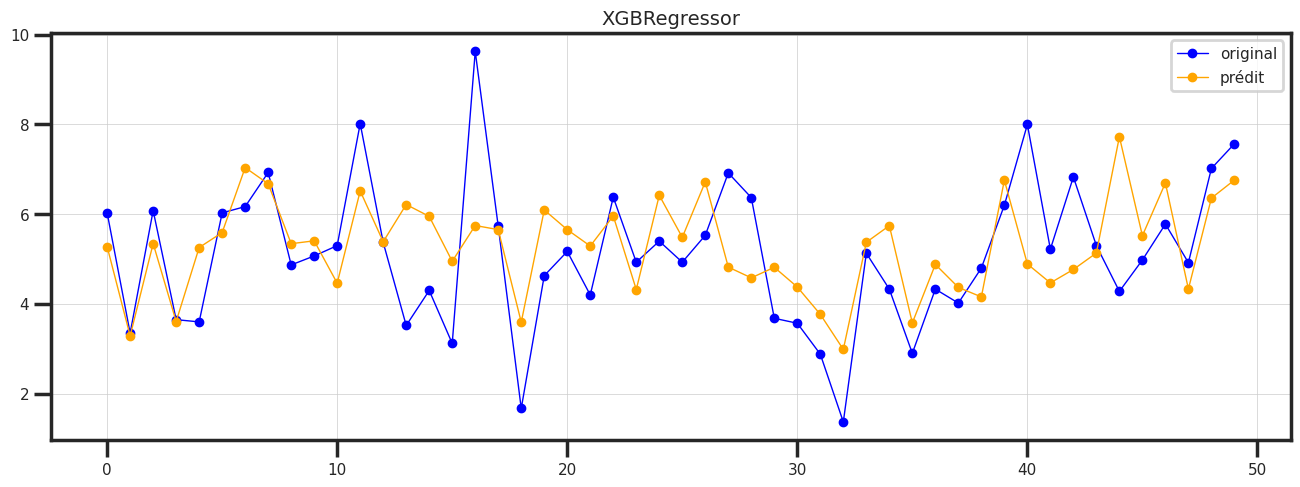

In [73]:
# Liste des modèles à évaluer après l'optimisation des hyperparamètres
models = [model]

# Pour chaque modèle, générer un graphique comparant les valeurs originales aux valeurs prédites
for i, model in enumerate(models):
    plt.figure(figsize=(16, 18))
    plt.subplot(3, 1, i + 1)
    predictions_graph(model)


#### Analyse des résidus

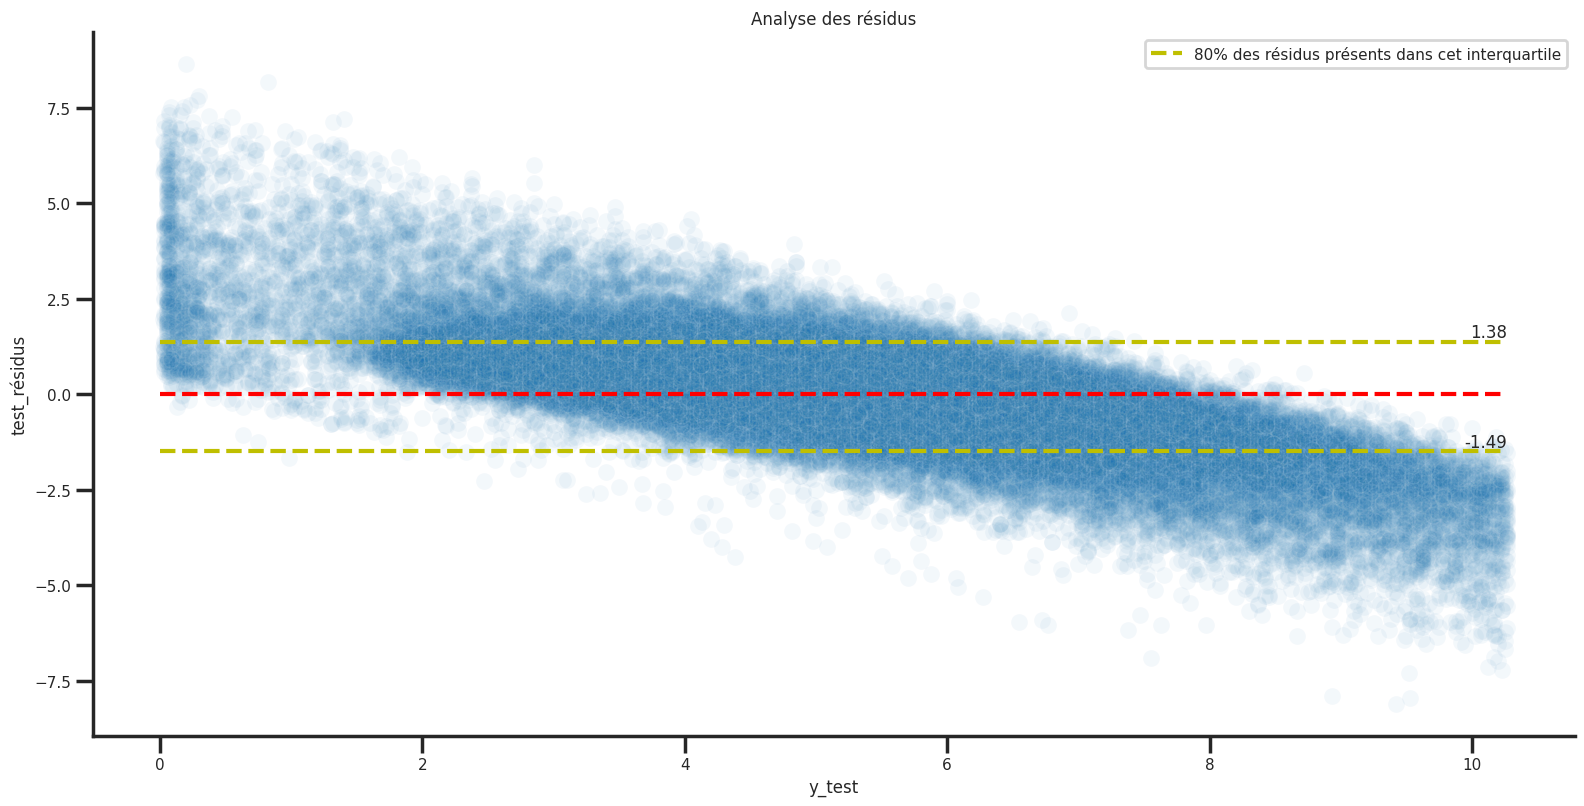

In [74]:
# Prédiction du modèle
y_test_pred = model.predict(X_test)

# Calcul des résidus
residus = y_test_pred - y_test

# Calcul des quantiles
quantiles = np.quantile(residus, [0.10, 0.90])

sns.relplot(x=y_test, y=residus, alpha=0.05, height=8, aspect=50/25)
plt.plot([0, y_test.max()], [0, 0], 'r--')
plt.plot([0, y_test.max()], [quantiles[0], quantiles[0]], 'y--', label="80% des résidus présents dans cet interquartile")
plt.plot([0, y_test.max()], [quantiles[1], quantiles[1]], 'y--')

# Ajout des annotations
plt.text(y_test.max(), quantiles[0], f'{quantiles[0]:.2f}', verticalalignment='bottom', horizontalalignment='right')
plt.text(y_test.max(), quantiles[1], f'{quantiles[1]:.2f}', verticalalignment='bottom', horizontalalignment='right')

plt.xlabel("y_test")
plt.ylabel("test_résidus")
plt.title("Analyse des résidus")
plt.legend()
plt.show();

<b> NOTES :</b> <br>
-  80% des résidus sont entre - 1.49 et 1.38.
- c.a.d, Dans 80% des cas, l'erreur de nos prédictions se trouve entre -1.48 et 1.38 minutes.

In [76]:
predictions = model.predict(X)
df['Predictions'] = predictions

In [77]:
df.iloc[1]

IncidentGroupType                        Special Service - Road Traffic Collision
BoroughName                                                               Croydon
WardName                                                            South Croydon
HourOfCall                                                                    0.0
PropertyType                                                        Vehicle - Car
DeployedFromStationName                                                 Addington
Distance                                                                     2.55
NumStationsWithPumpsAttending                                                 1.0
LatitudeIncident                                                        51.362452
LongitudeIncident                                                       -0.068299
LatitudeStation                                                         51.358043
LongitudeStation                                                        -0.032222
SecondPumpArrivi

# 10. Interprétabilité du modèle

### 10A. Interprétabilité globale (impact des variables sur plusieurs prédictions) : Summary_plot

In [78]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.3 MB/s eta 0:00:00


In [79]:
import shap

#Sélection d'un échantillon de X_test + transformation de la matric sparse en dataframe
X_test_transformed = model.named_steps['preprocessor'].transform(X_test.sample(100,random_state=42))
X_test_transformed_df = pd.DataFrame.sparse.from_spmatrix(X_test_transformed)

# Création de l'explainer
explainer = shap.TreeExplainer(model.named_steps['estimator'])

#Calcul des valeurs SHAP pour les instances de test
shap_values = explainer.shap_values(X_test_transformed)

In [80]:
# Récupération des noms de variables après preprocessing
categorical_transformed = categorical_transformer.fit_transform(X_train[categorical_features(X_test)])
categorical_feature_names = categorical_transformer.get_feature_names_out()
onehot_columns = list(categorical_feature_names)

numeric_features_list = numeric_features(X_train)
all_features = numeric_features_list + onehot_columns

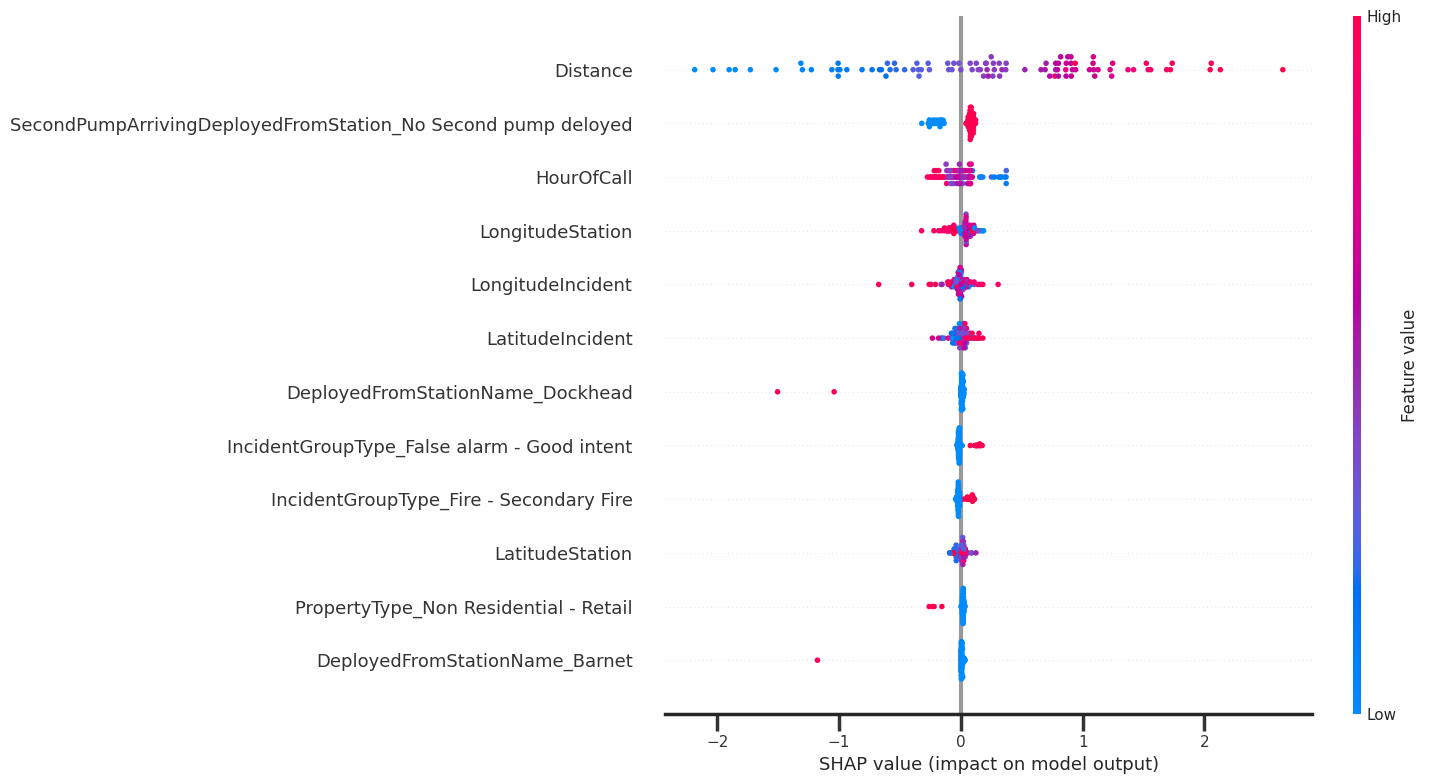

In [81]:
shap.summary_plot(shap_values,X_test_transformed_df,feature_names=all_features,max_display=12,plot_size=(15,8))

<b> NOTES :</b> <br>
- On observe que plus la distance augmente, plus le temps de réponse augmente.
- Quand l'heure de l'appel diminue, le temps de réponse augmente
- Quand une deuxième caserne est n'est pas déployée, temps de réponse augmente

### 10B. Interprétabilité locale (impact des variables sur 1 prédiction) : force_plot

Valeur réelle: 5.37


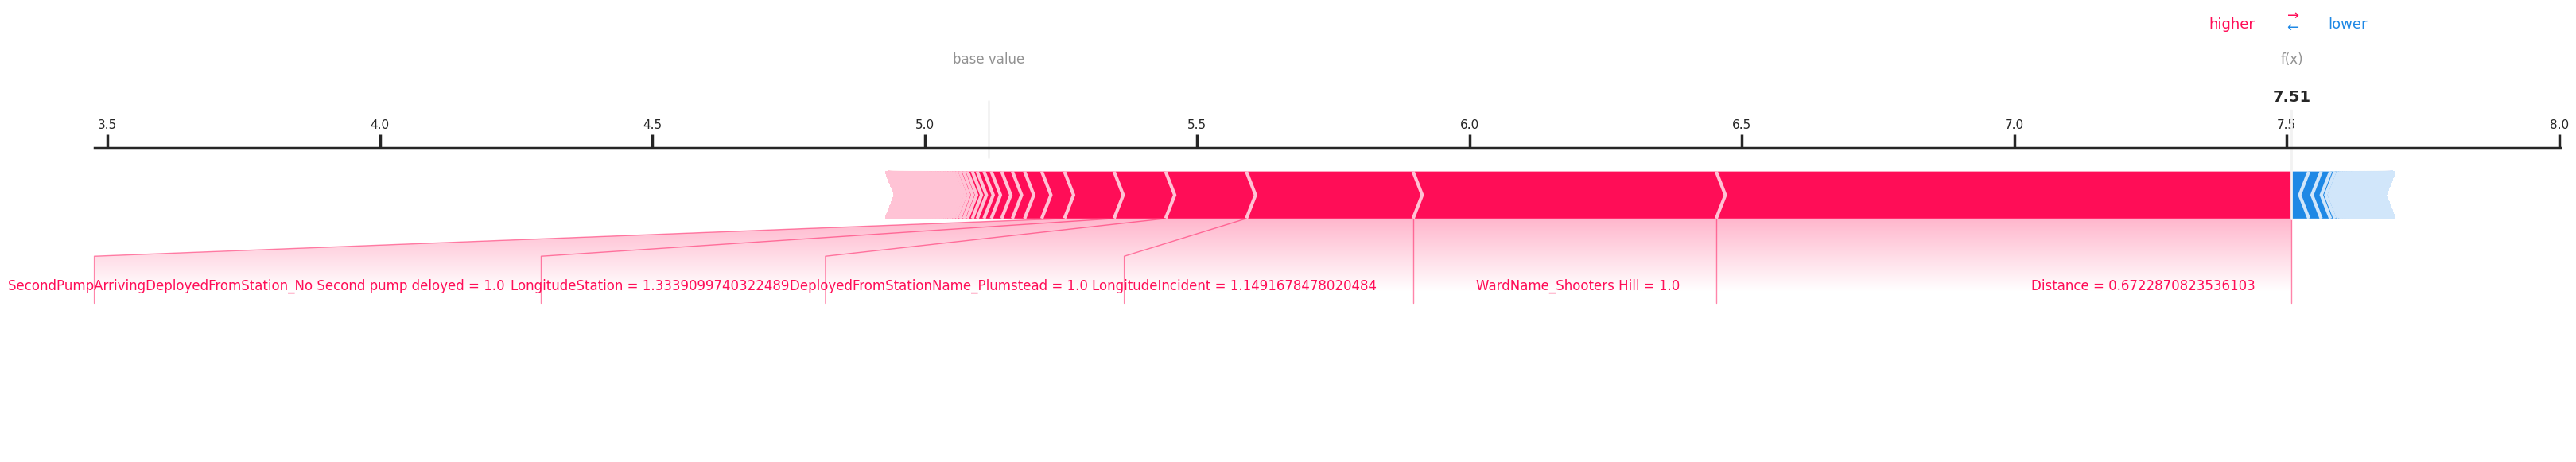

In [82]:
i=12

# Ajoutez la valeur réelle au graphique
print(f'Valeur réelle: {y_test.iloc[i]}')

shap.force_plot(explainer.expected_value, shap_values[i,:], X_test_transformed_df.iloc[i,:],
                link="identity", matplotlib=True, feature_names=all_features, figsize=(40,5))
